In [35]:
# Install necessary library
!pip install segmentation_models --quiet
!pip install -U tensorflow keras segmentation-models --quiet

In [36]:
# List existing image files (zipped)
!ls

cpu  landcoverai  landcoverai-20250306T133829Z-001.zip	models


In [37]:
pwd

'/project'

In [38]:
# Necessary because of a bug https://github.com/qubvel/segmentation_models/issues/374
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [39]:
!pip install matplotlib scikit-learn --quiet

In [40]:
import os
import random
from pathlib import Path

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models as sm
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
# In case the model gets very slow, may be due to a bug in TF2.0. Uncomment this.
# https://github.com/tensorflow/tensorflow/issues/33024
# tf.compat.v1.disable_eager_execution()

# Also check this in case you notice training to be getting increasingly slow each epoch.
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch

In [42]:
# Define needed directory paths
dir_root = Path("/project/landcoverai/")
dir_train_img = Path(dir_root, "train_images/train/")
dir_train_mask = Path(dir_root, "train_masks/train/")
dir_val_img = Path(dir_root, "val_images/val/")
dir_val_mask = Path(dir_root, "val_masks/val/")
dir_models = Path("/project/models/")




# Show how many image files exist
for dir in [dir_train_img, dir_train_mask, dir_val_img, dir_val_mask]:
    files = patch_files = [file for file in dir.iterdir()]
    print(f"{dir} has {len(files)} images.")

/project/landcoverai/train_images/train has 2250 images.
/project/landcoverai/train_masks/train has 2250 images.
/project/landcoverai/val_images/val has 750 images.
/project/landcoverai/val_masks/val has 750 images.


In [43]:
classes = {
    0: "Not classified",
    1: "Building",
    2: "Woodland",
    3: "Water",
    4: "Roads",
}

### Visualize random patch alongside its mask

In [44]:
def plot_image_and_mask(image: Path):
    """
    Function to plot an image alongside its mask.
    """
    img = cv2.imread(image.as_posix())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_path = Path(image.as_posix().replace("/train_images/", "/train_masks/"))
    mask = cv2.imread(mask_path.as_posix())

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img)
    ax1.set_title("Channel 0")

    norm = mpl.colors.Normalize(vmin=0, vmax=4)
    cmap = plt.get_cmap("viridis")

    ax2.imshow(mask[:, :, 1], cmap=cmap, norm=norm)
    ax2.set_title("Mask")

    plt.show()


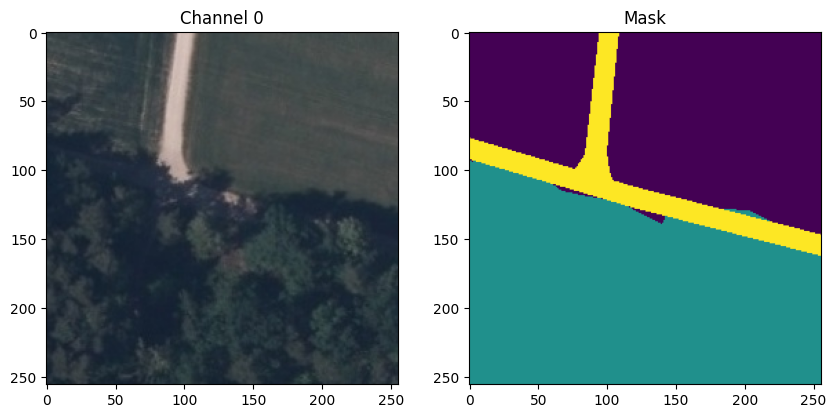

In [45]:
# Get paths of all images
img_files = [file for file in dir_train_img.iterdir()]

# Get random image from all images
img_path = np.random.choice(img_files)

plot_image_and_mask(img_path)


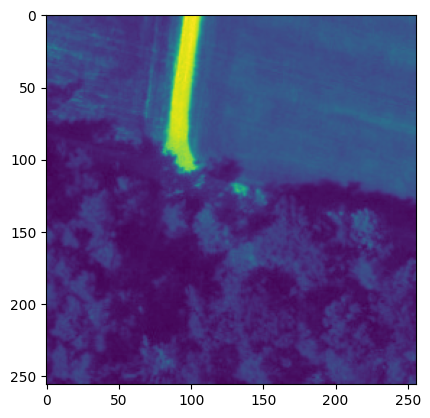

In [46]:
#Quick understanding of the dataset
temp_img = cv2.imread(img_path) #3 channels / spectral bands
plt.imshow(temp_img[:,:,0]) #View each channel...
plt.imshow(temp_img[:,:,1]) #View each channel...
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread(img_path) #3 channels but all same.






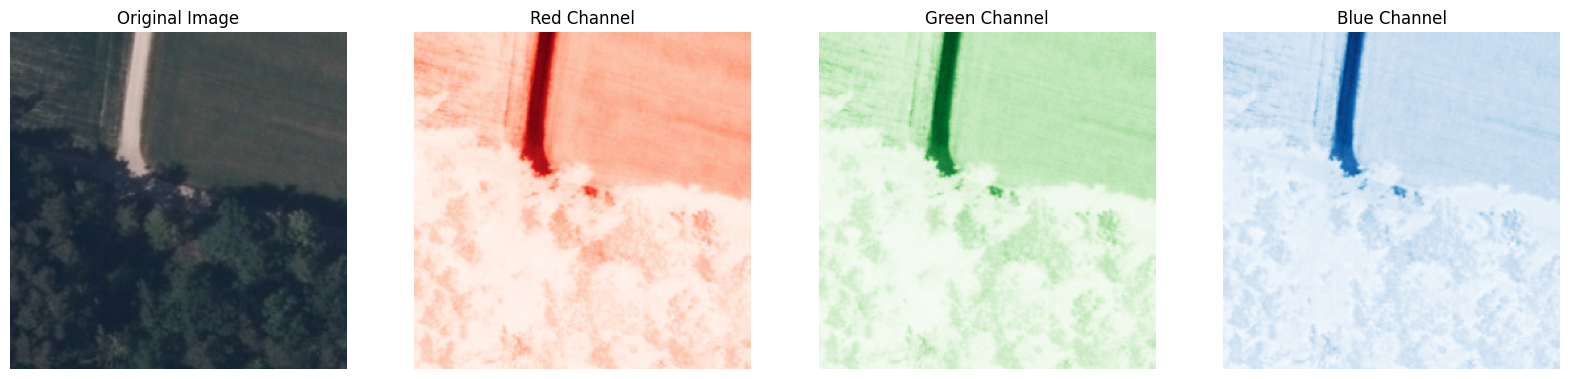

In [47]:


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread(img_path)  # Reads in BGR format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Split the channels
red_channel = img[:, :, 0]  # Red channel
green_channel = img[:, :, 1]  # Green channel
blue_channel = img[:, :, 2]  # Blue channel

# Plot the channels
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img)  # Original image
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(red_channel, cmap="Reds")
axs[1].set_title("Red Channel")
axs[1].axis("off")

axs[2].imshow(green_channel, cmap="Greens")
axs[2].set_title("Green Channel")
axs[2].axis("off")

axs[3].imshow(blue_channel, cmap="Blues")
axs[3].set_title("Blue Channel")
axs[3].axis("off")

plt.show()

In [48]:
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191]  and the counts are:  [   1    2    6   26   72  145  353  530 1009 1521 2095 2593 2733 2623
 2306 1951 1768 1570 1513 1468 1392 1378 1358 1366 1476 1429 1528 1508
 1499 1564 1550 1513 1992 2330 2863 3100 3041 2466 1928 1259  776  494
  339  256  185  170  112  101   74   57   50   46   46   38   40   29
   22   20   16   25   28   15   16   12   15   14    8   10   

In [49]:
import numpy as np

# Example: Assume temp_mask[:,:,0] contains many unique labels
labels, count = np.unique(temp_mask[:, :, 0], return_counts=True)
print("Original Labels:", labels)

# Create a mapping dictionary to reassign labels to [0,1,2,3,...]
# Ensure all labels in temp_mask are included in the mapping
label_mapping = {old_label: new_label for new_label, old_label in enumerate(labels)} #Changed labels[:4] to labels

# Apply mapping to mask
remapped_mask = np.vectorize(label_mapping.get)(temp_mask[:, :, 0])

# Print new unique labels
new_labels, new_count = np.unique(remapped_mask, return_counts=True)
print("New Labels:", new_labels)
print("New Counts:", new_count)

Original Labels: [ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191]
New Labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86 

### Define Generator for images and masks

In [50]:

import segmentation_models as sm

seed = 24
batch_size = 16  # Lower to 8 in case of memory issues
n_classes = len(classes)
encoder_freeze = True

# Use this to preprocess input for transfer learning
BACKBONE = "resnet152"
preprocess_input = sm.get_preprocessing(BACKBONE) # Now sm is defined and this line should work.

In [51]:
print(n_classes)

5


In [52]:
def preprocess_data(img, mask, num_class):
    """
    Function to perform additional preprocessing after datagen.
    """
    scaler = MinMaxScaler()

    # Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

    # Preprocess based on the pretrained backbone
    img = preprocess_input(img)

    # Convert mask to one-hot
    mask = to_categorical(mask, num_class)

    return (img, mask)


In [53]:


def trainGenerator(train_img_path, train_mask_path, num_class):
    """
    Function to define the generator.
    We are not doing any zoom to make sure mask values are not interpolated.
    It is important to keep pixel values in mask as 0, 1, 2, 3, ...
    """
    img_data_gen_args = dict(
        horizontal_flip=True, vertical_flip=True, fill_mode="reflect"
    )

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        str(train_img_path),
        class_mode=None,
        batch_size=batch_size,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_directory(
        str(train_mask_path),
        class_mode=None,
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
    )

    train_generator = zip(image_generator, mask_generator)

    for img, mask in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [54]:
train_img_gen = trainGenerator(dir_train_img.parent, dir_train_mask.parent, num_class=n_classes)
val_img_gen = trainGenerator(dir_val_img.parent, dir_val_mask.parent, num_class=n_classes)

In [55]:
print(train_img_gen)
print(val_img_gen)

<generator object trainGenerator at 0x768bd88b09c0>
<generator object trainGenerator at 0x768bcca98fb0>


### Visualize some images to check

Make sure the generator is working and that images and masks are indeed lined up.

Found 2250 images belonging to 1 classes.
Found 2250 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


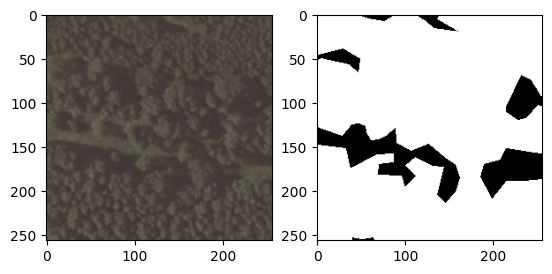

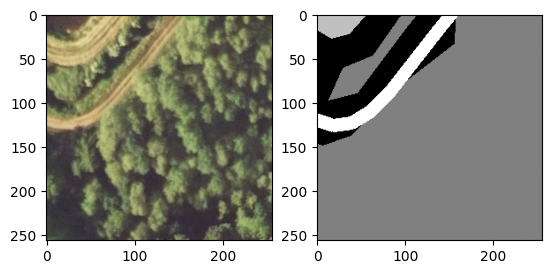

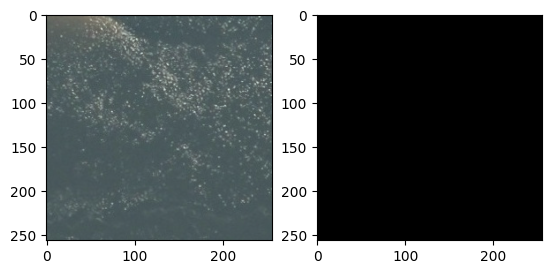

In [56]:
# Load the next batch of batch_size images
x, y = train_img_gen.__next__()

print(x.shape, y.shape)

# Make sure x has 3 layers (RGB)
assert x.shape[3] == 3

# Make sure y has n_classes layers
assert y.shape[3] == n_classes

for i in range(0, 3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()

Found 750 images belonging to 1 classes.
Found 750 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


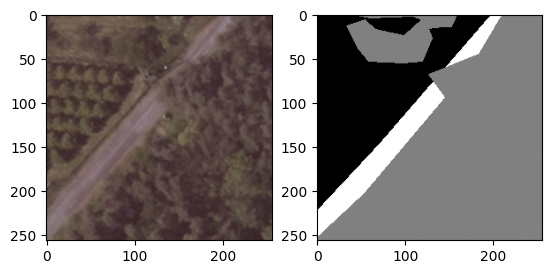

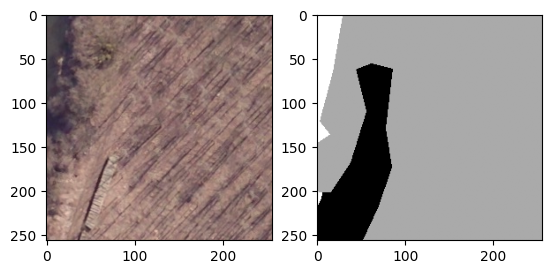

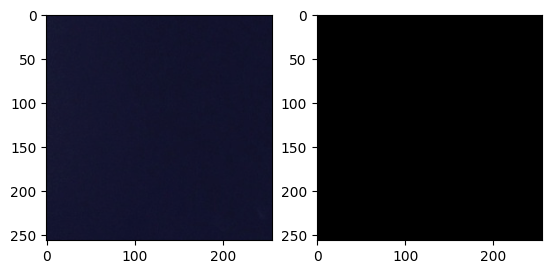

In [57]:
x_val, y_val = val_img_gen.__next__()

print(x_val.shape, y_val.shape)

# Make sure x has 3 layers (RGB)
assert x_val.shape[3] == 3

# Make sure y has n_classes layers
assert y_val.shape[3] == n_classes

for i in range(0, 3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()


### Define the model metrics and load model

In [58]:
num_train_imgs = len([file for file in dir_train_img.iterdir() if file.is_file()])
num_val_images = len([file for file in dir_val_img.iterdir() if file.is_file()])

steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH = x.shape[2]
IMG_CHANNELS = x.shape[3]

EPOCHS = 100

In [59]:
print(num_train_imgs)
print(num_val_images)
print(steps_per_epoch)
print(val_steps_per_epoch)

2250
750
140
46


### Use transfer learning using pretrained encoder in the U-Net

We use ***Intersection over Union (IoU)*** as evaluation metric (see [here](https://towardsdatascience.com/iou-a-better-detection-evaluation-metric-45a511185be1)). is used when calculating Mean average precision (mAP). It is a number from 0 to 1 that specifies the amount of overlap between the predicted and ground truth bounding box:

- an IoU of 0 means that there is no overlap between the boxes
- an IoU of 1 means that the union of the boxes is the same as their overlap indicating that they are completely overlapping

In [60]:
# Define the model
model = sm.Unet(
    BACKBONE,
    encoder_weights="imagenet",
    encoder_freeze=encoder_freeze,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    classes=len(classes),
    activation="softmax",
)
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import tensorflow as  tf


def custom_iou_score(gt, pr, **kwargs):


    # Cast to float32 using Keras backend
    gt = tf.keras.backend.cast(gt, dtype='float32')
    pr = tf.keras.backend.cast(pr, dtype='float32')
    return sm.metrics.iou_score(gt, pr, **kwargs)


model.compile(
    "Adam",
    loss=sm.losses.categorical_focal_jaccard_loss,
    metrics=[custom_iou_score],
)

# Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

print(model.summary())
print(model.input_shape)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_52   │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d_5… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_53   │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_54   │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_5… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 64, 64,    │          0 │ stage1_unit1_bn3

 Total params: 67,295,774 (256.71 MB)

 Trainable params: 9,157,528 (34.93 MB)

 Non-trainable params: 58,138,246 (221.78 MB)

None
(None, 256, 256, 3)


In [61]:
from keras.callbacks import EarlyStopping

stop_early = EarlyStopping(
    monitor="val_iou_score", patience=7, verbose=1, mode='max'
)

In [62]:
# Fit the model
history = model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_img_gen,
    validation_steps=val_steps_per_epoch,
    callbacks=stop_early,
)

freeze = "freeze" if encoder_freeze else "nofreeze"

file_model = Path(
    dir_models, f"landcover_{BACKBONE}_{EPOCHS}_epochs_batch{batch_size}_{freeze}.hdf5"
)
model.save(file_model)

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 151s 543ms/step - custom_iou_score: 0.3733 - loss: 0.6597 - val_custom_iou_score: 0.0765 - val_loss: 1.2012
Epoch 2/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - custom_iou_score: 0.6288 - loss: 0.3933

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 36s 255ms/step - custom_iou_score: 0.5726 - loss: 0.4595 - val_custom_iou_score: 0.0925 - val_loss: 1.0538
Epoch 3/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - custom_iou_score: 0.5564 - loss: 0.4712

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 254ms/step - custom_iou_score: 0.5982 - loss: 0.4329 - val_custom_iou_score: 0.0736 - val_loss: 1.4155
Epoch 4/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.5311 - loss: 0.5044

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 249ms/step - custom_iou_score: 0.5956 - loss: 0.4405 - val_custom_iou_score: 0.0748 - val_loss: 1.3286
Epoch 5/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.6622 - loss: 0.3577

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 243ms/step - custom_iou_score: 0.6523 - loss: 0.3720 - val_custom_iou_score: 0.0752 - val_loss: 1.3288
Epoch 6/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7374 - loss: 0.2769

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.5617 - loss: 0.4780 - val_custom_iou_score: 0.2060 - val_loss: 0.9373
Epoch 7/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.6831 - loss: 0.3331

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - custom_iou_score: 0.5992 - loss: 0.4427 - val_custom_iou_score: 0.3498 - val_loss: 0.7628
Epoch 8/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.6622 - loss: 0.3677

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6711 - loss: 0.3537 - val_custom_iou_score: 0.5206 - val_loss: 0.5292
Epoch 9/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7374 - loss: 0.2880

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6099 - loss: 0.4295 - val_custom_iou_score: 0.4226 - val_loss: 0.6574
Epoch 10/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.5890 - loss: 0.4384

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.5823 - loss: 0.4575 - val_custom_iou_score: 0.5791 - val_loss: 0.4651
Epoch 11/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7366 - loss: 0.2928

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.6442 - loss: 0.3920 - val_custom_iou_score: 0.6796 - val_loss: 0.3453
Epoch 12/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.6441 - loss: 0.3788

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6912 - loss: 0.3328 - val_custom_iou_score: 0.6621 - val_loss: 0.3668
Epoch 13/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.7071 - loss: 0.3088

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 221ms/step - custom_iou_score: 0.6797 - loss: 0.3457 - val_custom_iou_score: 0.5688 - val_loss: 0.4902
Epoch 14/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7590 - loss: 0.2590

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.6132 - loss: 0.4256 - val_custom_iou_score: 0.5742 - val_loss: 0.4689
Epoch 15/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7099 - loss: 0.3107

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6268 - loss: 0.4098 - val_custom_iou_score: 0.5820 - val_loss: 0.4636
Epoch 16/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.6707 - loss: 0.3490

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6252 - loss: 0.4140 - val_custom_iou_score: 0.5647 - val_loss: 0.4863
Epoch 17/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7204 - loss: 0.3031

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6382 - loss: 0.3959 - val_custom_iou_score: 0.6189 - val_loss: 0.4246
Epoch 18/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.8098 - loss: 0.2009

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.6618 - loss: 0.3719 - val_custom_iou_score: 0.6468 - val_loss: 0.3927
Epoch 19/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.7864 - loss: 0.2321

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6751 - loss: 0.3572 - val_custom_iou_score: 0.6236 - val_loss: 0.4155
Epoch 20/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7821 - loss: 0.2336

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.7038 - loss: 0.3228 - val_custom_iou_score: 0.6708 - val_loss: 0.3592
Epoch 21/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7112 - loss: 0.3209

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6692 - loss: 0.3631 - val_custom_iou_score: 0.5904 - val_loss: 0.4601
Epoch 22/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7845 - loss: 0.2342

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.6363 - loss: 0.4007 - val_custom_iou_score: 0.6412 - val_loss: 0.3967
Epoch 23/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7433 - loss: 0.2767

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.6735 - loss: 0.3579 - val_custom_iou_score: 0.6611 - val_loss: 0.3746
Epoch 24/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7460 - loss: 0.2726

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7135 - loss: 0.3102 - val_custom_iou_score: 0.5600 - val_loss: 0.4903
Epoch 25/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7837 - loss: 0.2340

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6350 - loss: 0.4018 - val_custom_iou_score: 0.5738 - val_loss: 0.4792
Epoch 26/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7747 - loss: 0.2447

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6267 - loss: 0.4097 - val_custom_iou_score: 0.6000 - val_loss: 0.4549
Epoch 27/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7820 - loss: 0.2323

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6420 - loss: 0.3926 - val_custom_iou_score: 0.6391 - val_loss: 0.3981
Epoch 28/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7463 - loss: 0.2697

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6622 - loss: 0.3682 - val_custom_iou_score: 0.6015 - val_loss: 0.4466
Epoch 29/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7964 - loss: 0.2253

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6509 - loss: 0.3837 - val_custom_iou_score: 0.6168 - val_loss: 0.4257
Epoch 30/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.7159 - loss: 0.3010

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - custom_iou_score: 0.6664 - loss: 0.3665 - val_custom_iou_score: 0.7107 - val_loss: 0.3140
Epoch 31/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8101 - loss: 0.2044

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7568 - loss: 0.2648 - val_custom_iou_score: 0.5974 - val_loss: 0.4543
Epoch 32/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7049 - loss: 0.3073

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6528 - loss: 0.3806 - val_custom_iou_score: 0.5886 - val_loss: 0.4680
Epoch 33/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7415 - loss: 0.2762

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6521 - loss: 0.3857 - val_custom_iou_score: 0.5730 - val_loss: 0.4755
Epoch 34/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7787 - loss: 0.2350

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6817 - loss: 0.3490 - val_custom_iou_score: 0.7342 - val_loss: 0.2862
Epoch 35/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.6861 - loss: 0.3205

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7696 - loss: 0.2475 - val_custom_iou_score: 0.5579 - val_loss: 0.5018
Epoch 36/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8115 - loss: 0.2048

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6402 - loss: 0.3996 - val_custom_iou_score: 0.6154 - val_loss: 0.4338
Epoch 37/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7194 - loss: 0.3045

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6928 - loss: 0.3384 - val_custom_iou_score: 0.7329 - val_loss: 0.2896
Epoch 38/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.8229 - loss: 0.1968

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 229ms/step - custom_iou_score: 0.7810 - loss: 0.2370 - val_custom_iou_score: 0.6316 - val_loss: 0.4105
Epoch 39/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7442 - loss: 0.2728

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6685 - loss: 0.3651 - val_custom_iou_score: 0.6066 - val_loss: 0.4424
Epoch 40/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.8224 - loss: 0.1927

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6602 - loss: 0.3767 - val_custom_iou_score: 0.7357 - val_loss: 0.2858
Epoch 41/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7055 - loss: 0.3105

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7746 - loss: 0.2427 - val_custom_iou_score: 0.6087 - val_loss: 0.4463
Epoch 42/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7394 - loss: 0.2811

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - custom_iou_score: 0.6656 - loss: 0.3702 - val_custom_iou_score: 0.7335 - val_loss: 0.2899
Epoch 43/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7797 - loss: 0.2338

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7741 - loss: 0.2422 - val_custom_iou_score: 0.6019 - val_loss: 0.4476
Epoch 44/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7089 - loss: 0.3078

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6545 - loss: 0.3832 - val_custom_iou_score: 0.7325 - val_loss: 0.2911
Epoch 45/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7680 - loss: 0.2465

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7786 - loss: 0.2388 - val_custom_iou_score: 0.5856 - val_loss: 0.4701
Epoch 46/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7953 - loss: 0.2230

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6523 - loss: 0.3842 - val_custom_iou_score: 0.5905 - val_loss: 0.4597
Epoch 47/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7785 - loss: 0.2412

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6701 - loss: 0.3672 - val_custom_iou_score: 0.7297 - val_loss: 0.2922
Epoch 48/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.6494 - loss: 0.3622

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.7715 - loss: 0.2466 - val_custom_iou_score: 0.6145 - val_loss: 0.4299
Epoch 49/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.8201 - loss: 0.1950

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6852 - loss: 0.3481 - val_custom_iou_score: 0.5998 - val_loss: 0.4473
Epoch 50/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7635 - loss: 0.2529

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6741 - loss: 0.3616 - val_custom_iou_score: 0.5975 - val_loss: 0.4510
Epoch 51/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.8607 - loss: 0.1456

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6870 - loss: 0.3469 - val_custom_iou_score: 0.5943 - val_loss: 0.4545
Epoch 52/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7202 - loss: 0.2949

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6755 - loss: 0.3582 - val_custom_iou_score: 0.7342 - val_loss: 0.2875
Epoch 53/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7849 - loss: 0.2279

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7877 - loss: 0.2281 - val_custom_iou_score: 0.5757 - val_loss: 0.4877
Epoch 54/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.8423 - loss: 0.1664

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.6671 - loss: 0.3677 - val_custom_iou_score: 0.7432 - val_loss: 0.2785
Epoch 55/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.8108 - loss: 0.2025

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7831 - loss: 0.2334 - val_custom_iou_score: 0.6080 - val_loss: 0.4395
Epoch 56/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.8114 - loss: 0.2056

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6586 - loss: 0.3777 - val_custom_iou_score: 0.7442 - val_loss: 0.2790
Epoch 57/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7949 - loss: 0.2240

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7896 - loss: 0.2269 - val_custom_iou_score: 0.5953 - val_loss: 0.4543
Epoch 58/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7546 - loss: 0.2699

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6567 - loss: 0.3808 - val_custom_iou_score: 0.7498 - val_loss: 0.2708
Epoch 59/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.8504 - loss: 0.1602

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7909 - loss: 0.2245 - val_custom_iou_score: 0.5935 - val_loss: 0.4554
Epoch 60/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.8374 - loss: 0.1778

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6873 - loss: 0.3462 - val_custom_iou_score: 0.5887 - val_loss: 0.4647
Epoch 61/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.8294 - loss: 0.1917

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6771 - loss: 0.3575 - val_custom_iou_score: 0.6046 - val_loss: 0.4450
Epoch 62/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.8095 - loss: 0.2061

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.6805 - loss: 0.3519 - val_custom_iou_score: 0.7461 - val_loss: 0.2750
Epoch 63/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.8075 - loss: 0.2097

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.7992 - loss: 0.2154 - val_custom_iou_score: 0.7437 - val_loss: 0.2771
Epoch 64/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.8419 - loss: 0.1728

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7955 - loss: 0.2208 - val_custom_iou_score: 0.6090 - val_loss: 0.4448
Epoch 65/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.8038 - loss: 0.2135

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.6792 - loss: 0.3556 - val_custom_iou_score: 0.6112 - val_loss: 0.4331
Epoch 66/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.8255 - loss: 0.1883

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7015 - loss: 0.3294 - val_custom_iou_score: 0.6279 - val_loss: 0.4169
Epoch 67/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.7910 - loss: 0.2272

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6957 - loss: 0.3380 - val_custom_iou_score: 0.6157 - val_loss: 0.4317
Epoch 68/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8247 - loss: 0.1891

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6841 - loss: 0.3510 - val_custom_iou_score: 0.5988 - val_loss: 0.4515
Epoch 69/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8253 - loss: 0.1855

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6731 - loss: 0.3634 - val_custom_iou_score: 0.5790 - val_loss: 0.4782
Epoch 70/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.8792 - loss: 0.1298

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7191 - loss: 0.3115 - val_custom_iou_score: 0.5953 - val_loss: 0.4540
Epoch 71/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8514 - loss: 0.1572

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6792 - loss: 0.3567 - val_custom_iou_score: 0.6143 - val_loss: 0.4356
Epoch 72/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.8479 - loss: 0.1677

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6748 - loss: 0.3601 - val_custom_iou_score: 0.5931 - val_loss: 0.4578
Epoch 73/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.8168 - loss: 0.1974

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.7034 - loss: 0.3283 - val_custom_iou_score: 0.6038 - val_loss: 0.4530
Epoch 74/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.8864 - loss: 0.1257

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6792 - loss: 0.3572 - val_custom_iou_score: 0.7173 - val_loss: 0.3115
Epoch 75/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.7780 - loss: 0.2377

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7864 - loss: 0.2313 - val_custom_iou_score: 0.6063 - val_loss: 0.4456
Epoch 76/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7403 - loss: 0.2742

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.6892 - loss: 0.3435 - val_custom_iou_score: 0.5826 - val_loss: 0.4739
Epoch 77/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7774 - loss: 0.2381

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6595 - loss: 0.3776 - val_custom_iou_score: 0.7438 - val_loss: 0.2780
Epoch 78/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.8030 - loss: 0.2104

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.8118 - loss: 0.2027 - val_custom_iou_score: 0.6295 - val_loss: 0.4133
Epoch 79/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.8598 - loss: 0.1465

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6947 - loss: 0.3403 - val_custom_iou_score: 0.6207 - val_loss: 0.4260
Epoch 80/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.8193 - loss: 0.1922

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6951 - loss: 0.3384 - val_custom_iou_score: 0.7546 - val_loss: 0.2656
Epoch 81/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.8470 - loss: 0.1672

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.8149 - loss: 0.1993 - val_custom_iou_score: 0.5982 - val_loss: 0.4562
Epoch 82/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.8471 - loss: 0.1685

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7125 - loss: 0.3191 - val_custom_iou_score: 0.6173 - val_loss: 0.4357
Epoch 83/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8205 - loss: 0.1952

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7130 - loss: 0.3183 - val_custom_iou_score: 0.6150 - val_loss: 0.4325
Epoch 84/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7847 - loss: 0.2301

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6873 - loss: 0.3464 - val_custom_iou_score: 0.6485 - val_loss: 0.3912
Epoch 85/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.8025 - loss: 0.2103

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7069 - loss: 0.3242 - val_custom_iou_score: 0.6349 - val_loss: 0.4131
Epoch 86/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.8088 - loss: 0.2113

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6772 - loss: 0.3579 - val_custom_iou_score: 0.5933 - val_loss: 0.4586
Epoch 87/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.8034 - loss: 0.2076

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6973 - loss: 0.3370 - val_custom_iou_score: 0.6096 - val_loss: 0.4401
Epoch 88/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.8041 - loss: 0.2108

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6876 - loss: 0.3468 - val_custom_iou_score: 0.7533 - val_loss: 0.2686
Epoch 89/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.8522 - loss: 0.1623

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.8121 - loss: 0.2030 - val_custom_iou_score: 0.6132 - val_loss: 0.4393
Epoch 90/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7811 - loss: 0.2342

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6948 - loss: 0.3379 - val_custom_iou_score: 0.5957 - val_loss: 0.4621
Epoch 91/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.8132 - loss: 0.2023

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.6760 - loss: 0.3612 - val_custom_iou_score: 0.6110 - val_loss: 0.4440
Epoch 92/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.8695 - loss: 0.1395

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7103 - loss: 0.3214 - val_custom_iou_score: 0.6327 - val_loss: 0.4122
Epoch 93/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.8395 - loss: 0.1756

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6769 - loss: 0.3578 - val_custom_iou_score: 0.7522 - val_loss: 0.2702
Epoch 94/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8778 - loss: 0.1299

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.8240 - loss: 0.1899 - val_custom_iou_score: 0.7477 - val_loss: 0.2734
Epoch 95/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7825 - loss: 0.2286

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.8209 - loss: 0.1923 - val_custom_iou_score: 0.5889 - val_loss: 0.4692
Epoch 96/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7920 - loss: 0.2173

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7185 - loss: 0.3139 - val_custom_iou_score: 0.6397 - val_loss: 0.4043
Epoch 97/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.8651 - loss: 0.1486

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.7108 - loss: 0.3225 - val_custom_iou_score: 0.5773 - val_loss: 0.4819
Epoch 98/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.8535 - loss: 0.1594

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6882 - loss: 0.3451 - val_custom_iou_score: 0.6043 - val_loss: 0.4525
Epoch 99/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.8628 - loss: 0.1482

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - custom_iou_score: 0.6811 - loss: 0.3548 - val_custom_iou_score: 0.7486 - val_loss: 0.2726
Epoch 100/100
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.8097 - loss: 0.2103

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.8344 - loss: 0.1783 - val_custom_iou_score: 0.5863 - val_loss: 0.4686


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


### Plot training and validation IoU and loss at each epoch

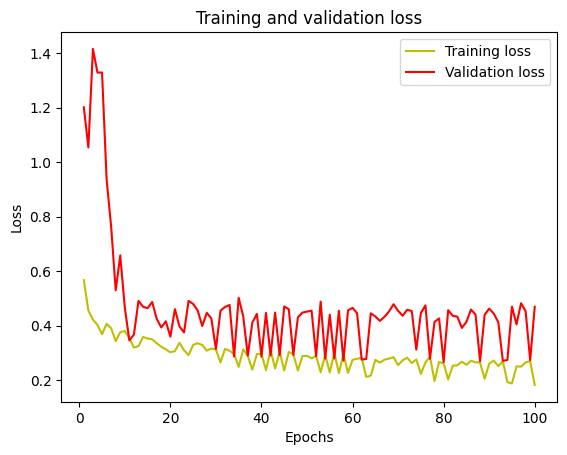

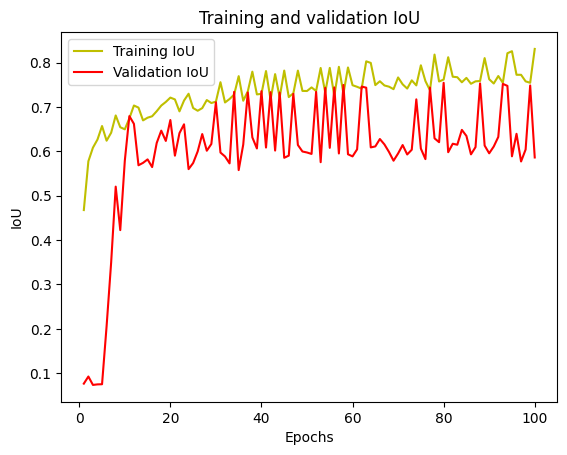

In [63]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["custom_iou_score"]
val_acc = history.history["val_custom_iou_score"]

plt.plot(epochs, acc, "y", label="Training IoU")
plt.plot(epochs, val_acc, "r", label="Validation IoU")
plt.title("Training and validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

In [64]:
print(model.input_shape, model.output_shape)


(None, 256, 256, 3) (None, 256, 256, 5)


### Evaulate model on test data

In [65]:

model = load_model(file_model, compile=False)
model.save(file_model)
# Test generator using validation data.
test_image_batch, test_mask_batch = val_img_gen.__next__()

# Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Mean IoU = 0.76138186


## Calculation

- Accuracy is typically used for classification tasks, where the goal is to predict discrete classes. In semantic segmentation, accuracy measures the percentage of pixels that are correctly classified.

- R-squared (R2) is commonly used in regression problems to measure the goodness of fit. It's less relevant in semantic segmentation, which is primarily a classification task.
- Mean Squared Error (MSE) is a regression metric that quantifies the average squared difference between predicted and true values. In semantic segmentation, it can be applied to the pixel-wise probabilities or class labels. However, it might not be the most informative metric for this task.
- Loss is the function used to optimize the model during training. In semantic segmentation, various loss functions can be employed, such as categorical cross-entropy or Dice loss. The loss value reflects the model's overall performance during training.

In [66]:
# Access the loss value from the training history
loss = history.history['loss'][-1]  # Get the last loss value
print("Loss:", loss)

from sklearn.metrics import mean_squared_error

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()  # Or use original probabilities
y_pred_flat = test_pred_batch_argmax.flatten()  # Or use original probabilities

# Calculate MSE
mse = mean_squared_error(y_true_flat, y_pred_flat)
print("Mean Squared Error:", mse)


from sklearn.metrics import accuracy_score

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()
y_pred_flat = test_pred_batch_argmax.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print("Accuracy:", accuracy)


# less Relevant
from sklearn.metrics import r2_score

# Assuming you have continuous predictions (e.g., probabilities)
y_true_flat = test_mask_batch.flatten()  # Use original probabilities
y_pred_flat = test_pred_batch.flatten()  # Use original probabilities

# Calculate R-squared
r2 = r2_score(y_true_flat, y_pred_flat)
print("R-squared:", r2)

Loss: 0.1818467527627945
Mean Squared Error: 0.5771360397338867
Accuracy: 0.9084882736206055
R-squared: 0.7889923587463111


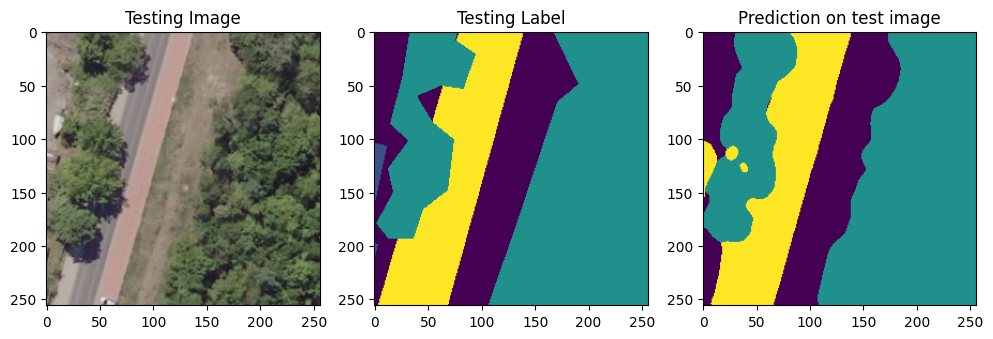

In [69]:
# View a few images, masks and corresponding predictions.
img_num = random.randint(0, test_image_batch.shape[0] - 1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title("Testing Image")
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title("Testing Label")
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title("Prediction on test image")
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()